In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
from itertools import chain
import copy
%matplotlib inline

In [2]:
xr.set_options(display_style='text')

In [3]:
rootdir = '/global/cscratch1/sd/feng045/SAAG/GPM/'
# idlfile = f'{rootdir}stats_4pyflex/robust_mcs_tracks_20190101_20190131.nc'
# pyfile = f'{rootdir}pyflex_test/stats/mcs_tracks_final_20190101.0000_20190131.2300.nc'
idlfile = f'{rootdir}stats_4pyflex/robust_mcs_tracks_20180601_20190630.nc'
pyfile = f'{rootdir}pyflex_test2/stats/mcs_tracks_final_20180601.0000_20190630.2300.nc'

topfile = '/global/project/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask_reg2imerg.nc'

figdir = f'/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cscratch1/sd/feng045/SAAG/GPM/pyflex_test2/figures/


In [4]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [5]:
def get_unique_placements(track_num, lat, lon, ntimes):
    """
    Get unique pairs of lat/lon for a track
    """
    # Put all lat/lon pairs over each time for a track into an array
    this_row = np.array([[lat[track_num, tt], lon[track_num, tt]] for tt in range(0, ntimes)])
    # Return the unique pairs (axis=0)
    return np.array(np.unique(this_row, axis=0))

def count_unique_mcs(lat, lon, xbins, ybins):
    
    ntracks, ntimes = lat.shape

    # A function to loop over tracks
    get_unique = lambda D: get_unique_placements(D, lat, lon, ntimes)

    # Loop over each track and get the unique pairs of lat/lon
    all_uniques = list(map(get_unique, np.arange(0, ntracks)))

    # Flatten the list of lat/lon pairs (using chain), and convert into an array
    unique_latlon = np.array(list(chain(*all_uniques)))

    # Count number on map using histogram2d
    ranges = [[min(ybins), max(ybins)], [min(xbins), max(xbins)]]
    hist2d, yedges, xedges = np.histogram2d(unique_latlon[:,0], unique_latlon[:,1], bins=[ybins, xbins], range=ranges)

    return hist2d

In [6]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.HGT.squeeze()
landmask = dstop.LANDMASK.squeeze()
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.lon
lat_ter = dstop.lat
dstop

<xarray.Dataset>
Dimensions:   (lat: 690, lon: 480, nbnd: 2)
Coordinates:
  * lat       (lat) float64 -55.95 -55.85 -55.75 -55.65 ... 12.75 12.85 12.95
  * lon       (lon) float64 278.1 278.2 278.2 278.4 ... 325.7 325.8 325.9 326.0
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds  (lat, nbnd) float64 ...
    lon_bnds  (lon, nbnd) float64 ...
    gw        (lat) float64 ...
    area      (lat, lon) float64 ...
    HGT       (lat, lon) float32 ...
    LAKEMASK  (lat, lon) float32 ...
    LANDMASK  (lat, lon) float32 ...
    LU_INDEX  (lat, lon) float32 ...
    XTIME     datetime64[ns] ...
Attributes: (12/154)
    TITLE:                            OUTPUT FROM WRF V4.1.5 MODEL
    START_DATE:                      2018-06-01_00:00:00
    SIMULATION_START_DATE:           2018-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1472
    SOUTH-NORTH_GRID_DIMENSION:      2028
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    history:                         Wed Jun  9 11:51:55 2021: ncks -O -t 1 -...
    remap_script:                    ncremap
    remap_hostname:                  cori04
    remap_version:                   4.7.9
    map_file:                        weight_wrf_imerg_conserve.nc
    input_file:                      /global/cscratch1/sd/feng045/SAAG/map_da...

In [7]:
dsidl = xr.open_dataset(idlfile)

In [8]:
dspy = xr.open_dataset(pyfile)

In [9]:
# [-82, -34, -56, 13]
# ranges = [[-56,13], [-82,-34]]
lonmin, lonmax = -82., -33.1
latmin, latmax = -56., 13.1
xbins = np.arange(lonmin, lonmax, 1)
ybins = np.arange(latmin, latmax, 1)

In [10]:
# Get track initial time valuees
base_time_idl = dsidl.base_time.load()
starttime_idl = base_time_idl.isel(times=0)
syear_idl = starttime_idl.dt.year.load()
season_idl = starttime_idl.dt.season.load()
# nyears_idl = len(np.unique(syear_idl))
# print(f'Number of unique years (OBS): {nyears_idl}')

In [11]:
# Get track initial time valuees
base_time_py = dspy.base_time.load()
starttime_py = base_time_py.isel(times=0)
syear_py = starttime_py.dt.year.load()
season_py = starttime_py.dt.season.load()
# nyears_py = len(np.unique(syear_py))
# print(f'Number of unique years (wrf): {nyears_py}')

In [12]:
# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_idl = dsidl.meanlat.load().round()
rlon_idl = dsidl.meanlon.load().round()

rlat_py = dspy.meanlat.load().round()
rlon_py = dspy.meanlon.load().round()
# rlon_py = ((dspy.meanlon.load().round() - 180) % 360) - 180

In [13]:
pflat_idl = dsidl.pf_lat.isel(nmaxpf=0).load().round()
pflon_idl = dsidl.pf_lon.isel(nmaxpf=0).load().round()

pflat_py = dspy.pf_lat.isel(nmaxpf=0).load().round()
pflon_py = dspy.pf_lon.isel(nmaxpf=0).load().round()

In [14]:
pflon_py.min().values, pflon_py.max().values

(array(-82., dtype=float32), array(-34., dtype=float32))

In [15]:
rlat_idl_DJF = rlat_idl.where(season_idl == 'DJF', drop=True)
rlon_idl_DJF = rlon_idl.where(season_idl == 'DJF', drop=True)
pflat_idl_DJF = pflat_idl.where(season_idl == 'DJF', drop=True)
pflon_idl_DJF = pflon_idl.where(season_idl == 'DJF', drop=True)
rlat_idl_MAM = rlat_idl.where(season_idl == 'MAM', drop=True)
rlon_idl_MAM = rlon_idl.where(season_idl == 'MAM', drop=True)
rlat_idl_JJA = rlat_idl.where(season_idl == 'JJA', drop=True)
rlon_idl_JJA = rlon_idl.where(season_idl == 'JJA', drop=True)
rlat_idl_SON = rlat_idl.where(season_idl == 'SON', drop=True)
rlon_idl_SON = rlon_idl.where(season_idl == 'SON', drop=True)

rlat_py_DJF = rlat_py.where(season_py == 'DJF', drop=True)
rlon_py_DJF = rlon_py.where(season_py == 'DJF', drop=True)
pflat_py_DJF = pflat_py.where(season_py == 'DJF', drop=True)
pflon_py_DJF = pflon_py.where(season_py == 'DJF', drop=True)
rlat_py_MAM = rlat_py.where(season_py == 'MAM', drop=True)
rlon_py_MAM = rlon_py.where(season_py == 'MAM', drop=True)
rlat_py_JJA = rlat_py.where(season_py == 'JJA', drop=True)
rlon_py_JJA = rlon_py.where(season_py == 'JJA', drop=True)
rlat_py_SON = rlat_py.where(season_py == 'SON', drop=True)
rlon_py_SON = rlon_py.where(season_py == 'SON', drop=True)

In [16]:
# Total MCS count
mcs_ircount_idl = count_unique_mcs(rlat_idl.values, rlon_idl.values, xbins, ybins)
mcs_ircount_py = count_unique_mcs(rlat_py.values, rlon_py.values, xbins, ybins)

mcs_pfcount_idl = count_unique_mcs(pflat_idl.values, pflon_idl.values, xbins, ybins)
mcs_pfcount_py = count_unique_mcs(pflat_py.values, pflon_py.values, xbins, ybins)

In [17]:
# Total MCS count by season
mcs_ircount_idl_DJF = count_unique_mcs(rlat_idl_DJF.values, rlon_idl_DJF.values, xbins, ybins)
mcs_ircount_py_DJF = count_unique_mcs(rlat_py_DJF.values, rlon_py_DJF.values, xbins, ybins)
mcs_ircount_idl_MAM = count_unique_mcs(rlat_idl_MAM.values, rlon_idl_MAM.values, xbins, ybins)
mcs_ircount_py_MAM = count_unique_mcs(rlat_py_MAM.values, rlon_py_MAM.values, xbins, ybins)
mcs_ircount_idl_JJA = count_unique_mcs(rlat_idl_JJA.values, rlon_idl_JJA.values, xbins, ybins)
mcs_ircount_py_JJA = count_unique_mcs(rlat_py_JJA.values, rlon_py_JJA.values, xbins, ybins)
mcs_ircount_idl_SON = count_unique_mcs(rlat_idl_SON.values, rlon_idl_SON.values, xbins, ybins)
mcs_ircount_py_SON = count_unique_mcs(rlat_py_SON.values, rlon_py_SON.values, xbins, ybins)

In [18]:
# Divide by the number of years to get annual mean
nyears = 1
mcs_irnumber_idl = mcs_ircount_idl / nyears
mcs_irnumber_py = mcs_ircount_py / nyears
mcs_pfnumber_idl = mcs_pfcount_idl / nyears
mcs_pfnumber_py = mcs_pfcount_py / nyears

In [19]:
mcs_irnumber_idl_DJF = mcs_ircount_idl_DJF / nyears
mcs_irnumber_py_DJF = mcs_ircount_py_DJF / nyears
mcs_irnumber_idl_MAM = mcs_ircount_idl_MAM / nyears
mcs_irnumber_py_MAM = mcs_ircount_py_MAM / nyears
mcs_irnumber_idl_JJA = mcs_ircount_idl_JJA / nyears
mcs_irnumber_py_JJA = mcs_ircount_py_JJA / nyears
mcs_irnumber_idl_SON = mcs_ircount_idl_SON / nyears
mcs_irnumber_py_SON = mcs_ircount_py_SON / nyears

In [20]:
# lon0_py.plot()

In [21]:
lat0_idl = dsidl.meanlat.isel(times=0)
lon0_idl = dsidl.meanlon.isel(times=0)
# Convert [0-360] to [-180~+180]
lat0_py = dspy.meanlat.isel(times=0)
lon0_py = dspy.meanlon.isel(times=0)
# lat0_py = ((dspy.meanlat.isel(times=0) - 180) % 360) - 180
# lon0_py = ((dspy.meanlon.isel(times=0) - 180) % 360) - 180

xbins5 = np.arange(lonmin, lonmax, 3)
ybins5 = np.arange(latmin, latmax, 3)
ranges5 = [[min(ybins5), max(ybins5)], [min(xbins5), max(xbins5)]]
mcs_initcount_idl, yedges, xedges = np.histogram2d(lat0_idl, lon0_idl, bins=[ybins5, xbins5], range=ranges5)
mcs_initcount_py, yedges, xedges = np.histogram2d(lat0_py, lon0_py, bins=[ybins5, xbins5], range=ranges5)

In [22]:
# lat0_idl_DJF = lat0_idl.where(season_idl == 'DJF', drop=True)
# lon0_idl_DJF = lon0_idl.where(season_idl == 'DJF', drop=True)
# lat0_py_DJF = lat0_py.where(season_py == 'DJF', drop=True)
# lon0_py_DJF = lon0_py.where(season_py == 'DJF', drop=True)
# lat0_idl_MAM = lat0_idl.where(season_idl == 'MAM', drop=True)
# lon0_idl_MAM = lon0_idl.where(season_idl == 'MAM', drop=True)
# lat0_py_MAM = lat0_py.where(season_py == 'MAM', drop=True)
# lon0_py_MAM = lon0_py.where(season_py == 'MAM', drop=True)
# lat0_idl_JJA = lat0_idl.where(season_idl == 'JJA', drop=True)
# lon0_idl_JJA = lon0_idl.where(season_idl == 'JJA', drop=True)
# lat0_py_JJA = lat0_py.where(season_py == 'JJA', drop=True)
# lon0_py_JJA = lon0_py.where(season_py == 'JJA', drop=True)
# lat0_idl_SON = lat0_idl.where(season_idl == 'SON', drop=True)
# lon0_idl_SON = lon0_idl.where(season_idl == 'SON', drop=True)
# lat0_py_SON = lat0_py.where(season_py == 'SON', drop=True)
# lon0_py_SON = lon0_py.where(season_py == 'SON', drop=True)

# mcs_initcount_idl_DJF, yedges, xedges = np.histogram2d(lat0_idl_DJF, lon0_idl_DJF, bins=[ybins5, xbins5], range=ranges5)
# mcs_initcount_py_DJF, yedges, xedges = np.histogram2d(lat0_py_DJF, lon0_py_DJF, bins=[ybins5, xbins5], range=ranges5)
# mcs_initcount_idl_MAM, yedges, xedges = np.histogram2d(lat0_idl_MAM, lon0_idl_MAM, bins=[ybins5, xbins5], range=ranges5)
# mcs_initcount_py_MAM, yedges, xedges = np.histogram2d(lat0_py_MAM, lon0_py_MAM, bins=[ybins5, xbins5], range=ranges5)
# mcs_initcount_idl_JJA, yedges, xedges = np.histogram2d(lat0_idl_JJA, lon0_idl_JJA, bins=[ybins5, xbins5], range=ranges5)
# mcs_initcount_py_JJA, yedges, xedges = np.histogram2d(lat0_py_JJA, lon0_py_JJA, bins=[ybins5, xbins5], range=ranges5)
# mcs_initcount_idl_SON, yedges, xedges = np.histogram2d(lat0_idl_SON, lon0_idl_SON, bins=[ybins5, xbins5], range=ranges5)
# mcs_initcount_py_SON, yedges, xedges = np.histogram2d(lat0_py_SON, lon0_py_SON, bins=[ybins5, xbins5], range=ranges5)

In [23]:
# mcs_initcount_py

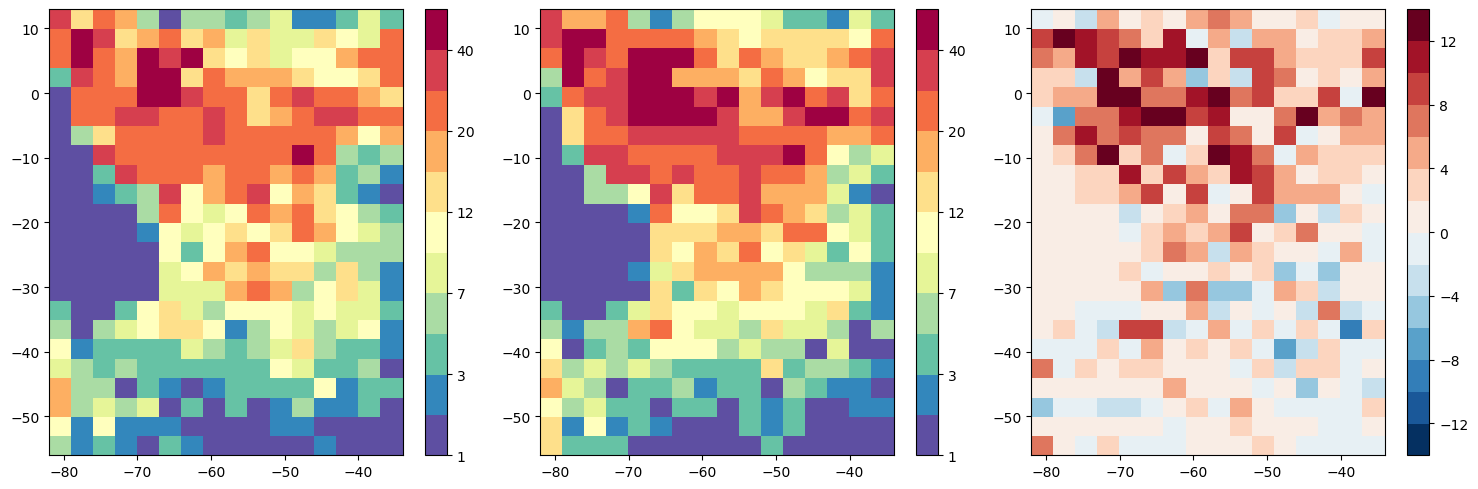

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
levels = [1,2,3,5,7,9,12,15,20,30,40,60]
# levels = [1,2,3,5,7,9,12,15,20,30]
# levels = np.arange(1,10,1)
levels_diff = np.arange(-14, 14.1, 2)
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
norm_diff = mpl.colors.BoundaryNorm(boundaries=levels_diff, ncolors=256)
mcs_initcount_diff = mcs_initcount_py - mcs_initcount_idl
pm1 = ax[0].pcolormesh(xbins5, ybins5, mcs_initcount_idl, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(xbins5, ybins5, mcs_initcount_py, shading='auto', norm=norm, cmap=cmap)
pm3 = ax[2].pcolormesh(xbins5, ybins5, mcs_initcount_diff, shading='auto', norm=norm_diff, cmap='RdBu_r')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

In [25]:
# fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
# levels = [2,3,5,7,9,12,15,20,30,40,60]
# cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
# norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
# mcs_initcount_diff = mcs_initcount_py - mcs_initcount_idl
# pm1 = ax[0].pcolormesh(xbins5, ybins5, mcs_initcount_idl, shading='auto', norm=norm, cmap=cmap)
# pm2 = ax[1].pcolormesh(xbins5, ybins5, mcs_initcount_py, shading='auto', norm=norm, cmap=cmap)
# pm3 = ax[2].pcolormesh(xbins5, ybins5, mcs_initcount_diff, shading='auto', vmin=-20, vmax=20, cmap='RdBu')
# plt.colorbar(pm1, ax=ax[0])
# plt.colorbar(pm2, ax=ax[1])
# plt.colorbar(pm3, ax=ax[2])
# fig.tight_layout()

In [26]:
mcs_initcount_diff.shape, xbins.shape, ybins.shape

((23, 16), (49,), (70,))

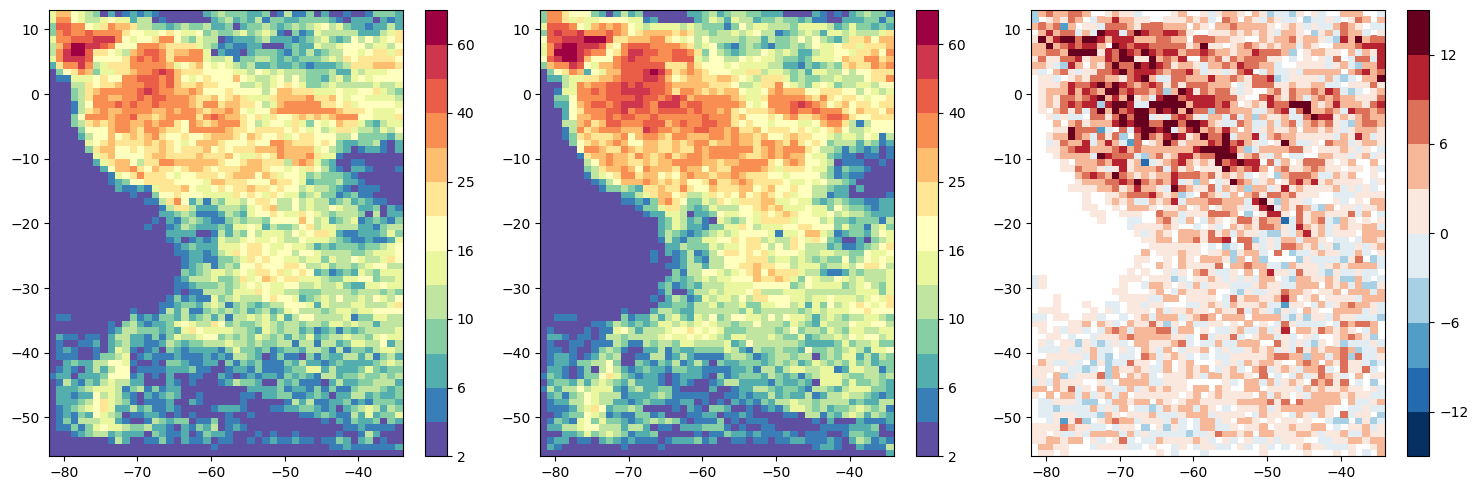

In [27]:
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
levels = [2,4,6,8,10,13,16,20,25,30,40,50,60,80]
# levels = np.arange(0,10,1)
levels_diff = np.arange(-15, 15.1, 3)
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
norm_diff = mpl.colors.BoundaryNorm(boundaries=levels_diff, ncolors=256)
mcs_irnumber_diff = mcs_irnumber_py - mcs_irnumber_idl
Zm = np.ma.masked_where(mcs_irnumber_diff == 0, mcs_irnumber_diff)
pm1 = ax[0].pcolormesh(xbins, ybins, mcs_irnumber_idl, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(xbins, ybins, mcs_irnumber_py, shading='auto', norm=norm, cmap=cmap)
pm3 = ax[2].pcolormesh(xbins, ybins, Zm, shading='auto', norm=norm_diff, cmap='RdBu_r')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

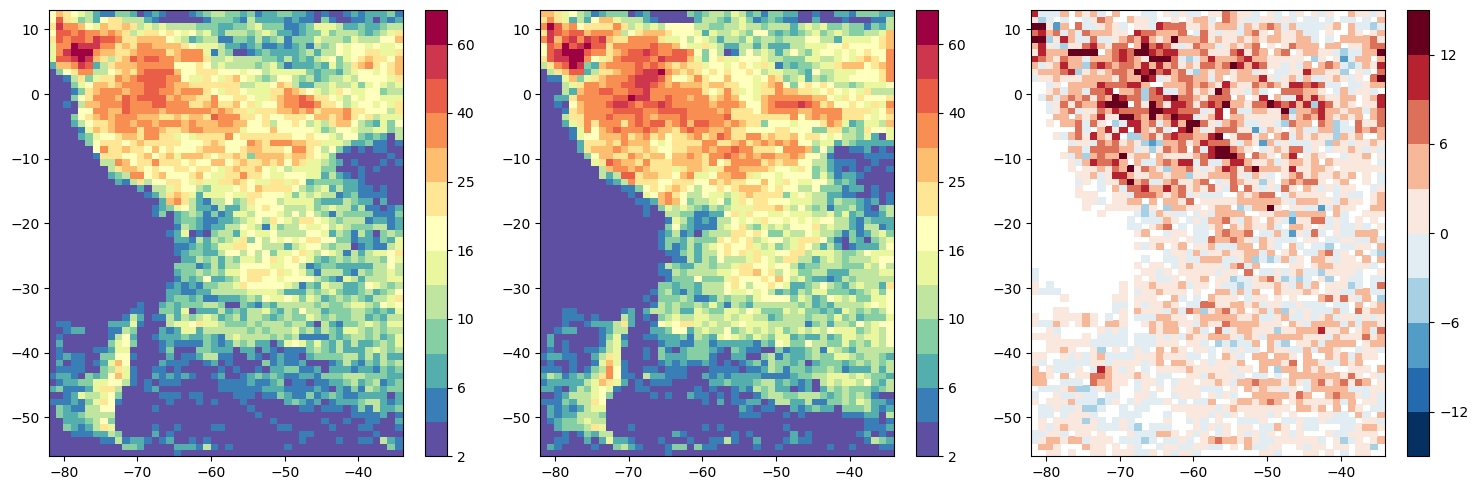

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
# levels = np.arange(0,10,1)
levels = [2,4,6,8,10,13,16,20,25,30,40,50,60,80]
levels_diff = np.arange(-15, 15.1, 3)
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
norm_diff = mpl.colors.BoundaryNorm(boundaries=levels_diff, ncolors=256)
mcs_pfnumber_diff = mcs_pfnumber_py - mcs_pfnumber_idl
pm1 = ax[0].pcolormesh(xbins, ybins, mcs_pfnumber_idl, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(xbins, ybins, mcs_pfnumber_py, shading='auto', norm=norm, cmap=cmap)
Zm = np.ma.masked_where(mcs_pfnumber_diff == 0, mcs_pfnumber_diff)
# levels_diff = np.arange(-4, 4.1, 1)
# norm = mpl.colors.BoundaryNorm(boundaries=levels_diff, ncolors=256)
pm3 = ax[2].pcolormesh(xbins, ybins, Zm, shading='auto', norm=norm_diff, cmap='RdBu_r')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

In [29]:
def plot_map_3panels(dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [-82, -34, -56, 13]
    lonv = list(np.arange(-180,180.1,10))
    latv = list(np.arange(-90,90.1,10))
    lonvals = mpl.ticker.FixedLocator(lonv)
    latvals = mpl.ticker.FixedLocator(latv)
    proj = ccrs.PlateCarree()
    levelshgt = [1000,6000]
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    fig = plt.figure(figsize=[14,5.5], dpi=100)
    
    for pp in range(0,3):
        ax = plt.subplot(1, 3, pp+1, projection=proj)
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
#         ax.set_extent(map_extend, ccrs.Geodetic())
#         ax.add_feature(land, facecolor='lightgray')
#         ax.add_feature(ocean, edgecolor='k', facecolor=cfeature.COLORS['water'])
#         ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)

        gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5, zorder=10)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = lonvals
        gl.ylocator = latvals
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        if (pp != 0):
            gl.left_labels = False
        
        data = dataarray[pp]
#         Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        Zm = np.ma.masked_where(((np.isnan(data))), data)
        cmap = copy.copy(mpl.cm.get_cmap(cmaps[pp]))
        norm = mpl.colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
#         cf1 = ax.contourf(lonarray[pp], latarray[pp], Zm, levels=levels[pp], norm=norm, cmap=cmaps[pp], transform=proj, zorder=2, extend='both')
#         norm = mpl.colors.BoundaryNorm(boundaries=levels[pp], ncolors=256)
#         cf1 = plt.contourf(lonarray[pp], latarray[pp], Zm, levels=levels[pp], norm=norm, cmap=cmaps[pp], transform=proj, zorder=2, extend='both')
        cf1 = ax.pcolormesh(lonarray, latarray, Zm, shading='auto', norm=norm, cmap=cmap, transform=proj, zorder=2)
        ax.set_title(titles[pp], loc='left')
        cb1 = plt.colorbar(cf1, ax=ax, label=cblabels[pp], pad=0.02, ticks=cbticks[pp], extend='both', aspect=30)
        if (oob_colors is not None) and (pp != 2):
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[pp]), max(levels[pp]))
#         ax.set_aspect('auto', adjustable=None)

        # Terrain height
#         ctf = ax.contourf(lon_ter, lat_ter, ter_s, levels=levelshgt, \
#                          colors='lightgray', transform=proj, zorder=1)
        ct = ax.contour(lon_ter, lat_ter, ter, levels=levelshgt, \
                        colors='dimgray', linewidths=1, transform=proj, zorder=3)

    # Work around to make tight_layout work 
    fig.canvas.draw()
    fig.tight_layout(w_pad=0.15)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

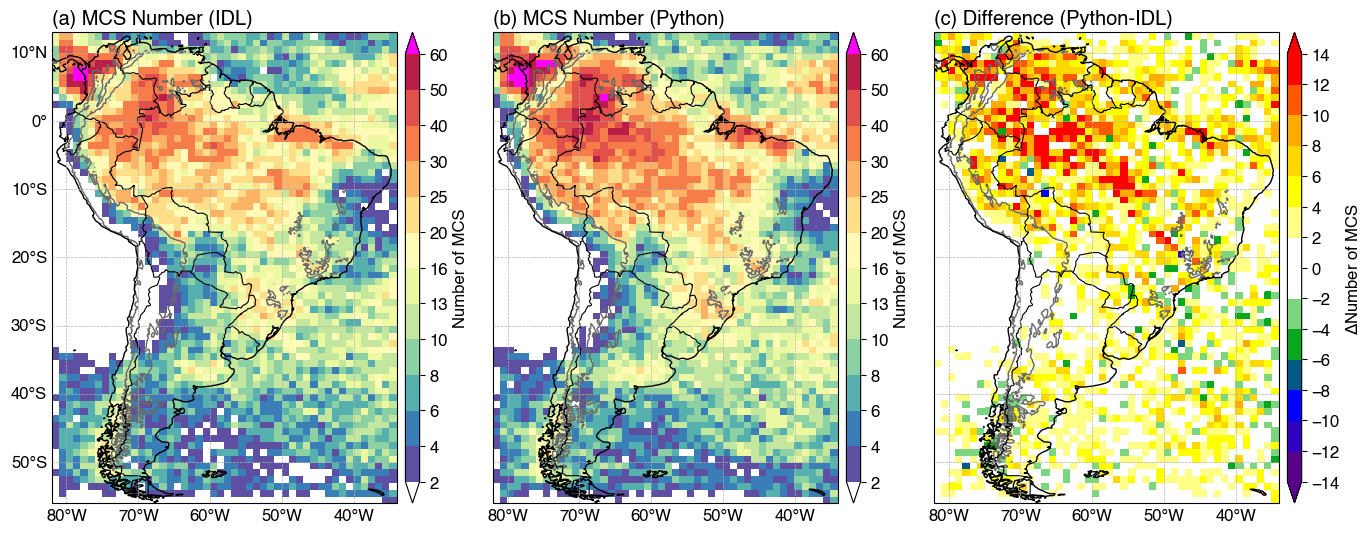

In [30]:
mcs_irnumber_diff = mcs_irnumber_py - mcs_irnumber_idl
mcs_irnumber_diff = np.ma.masked_where(mcs_irnumber_diff == 0, mcs_irnumber_diff)
dataarray = [mcs_irnumber_idl, mcs_irnumber_py, mcs_irnumber_diff]
# levels = [2,3,5,7,9,12,15,20,30,40,50,60]
# levels = np.arange(1,10.1,1)
# levelsdiff = np.arange(-5,5.1,1)
levels = [2,4,6,8,10,13,16,20,25,30,40,50,60]
levels_diff = np.arange(-14, 14.1, 2)
levels = [levels, levels, levels_diff]
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
# cmapdiff = copy.copy(mpl.cm.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) MCS Number (IDL)', f'(b) MCS Number (Python)', f'(c) Difference (Python-IDL)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}idl_python_mcs_irnumber_map_annual.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins, ybins, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

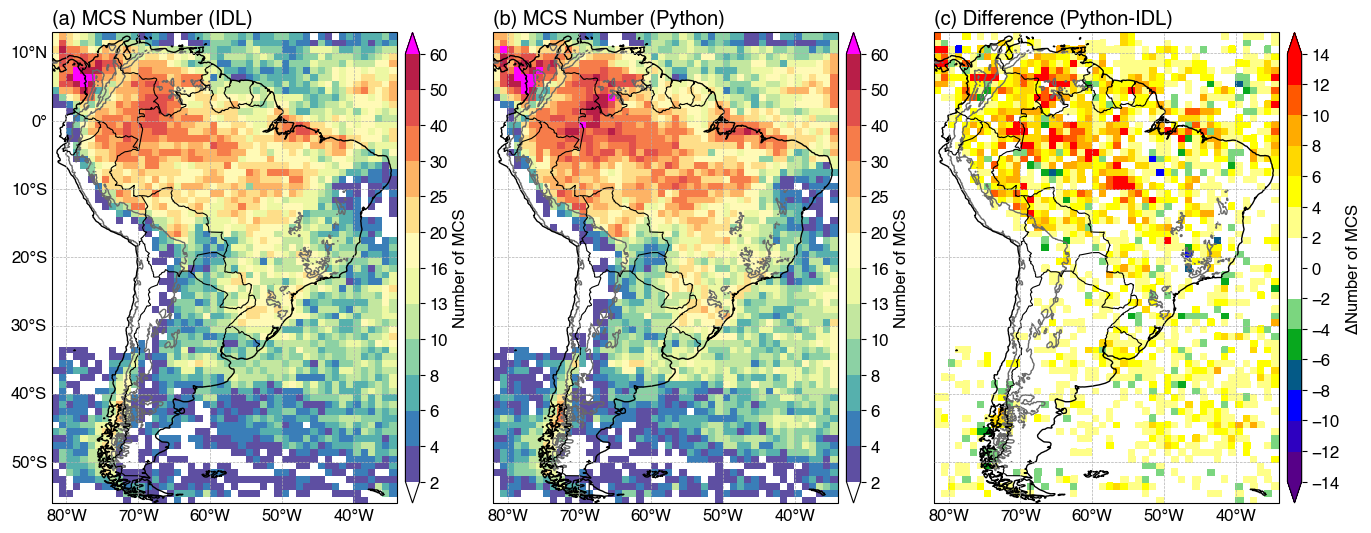

In [31]:
mcs_pfnumber_diff = mcs_pfnumber_py - mcs_pfnumber_idl
mcs_pfnumber_diff = np.ma.masked_where(mcs_pfnumber_diff == 0, mcs_pfnumber_diff)
dataarray = [mcs_pfnumber_idl, mcs_pfnumber_py, mcs_pfnumber_diff]
# levels = [2,3,5,7,9,12,15,20,30,40,50,60]
# levels = np.arange(1,10.1,1)
# levelsdiff = np.arange(-5,5.1,1)
levels = [2,4,6,8,10,13,16,20,25,30,40,50,60]
levels_diff = np.arange(-14, 14.1, 2)
levels = [levels, levels, levels_diff]
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
# cmapdiff = copy.copy(mpl.cm.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) MCS Number (IDL)', f'(b) MCS Number (Python)', f'(c) Difference (Python-IDL)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}idl_python_mcs_pfnumber_map_annual.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins, ybins, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)

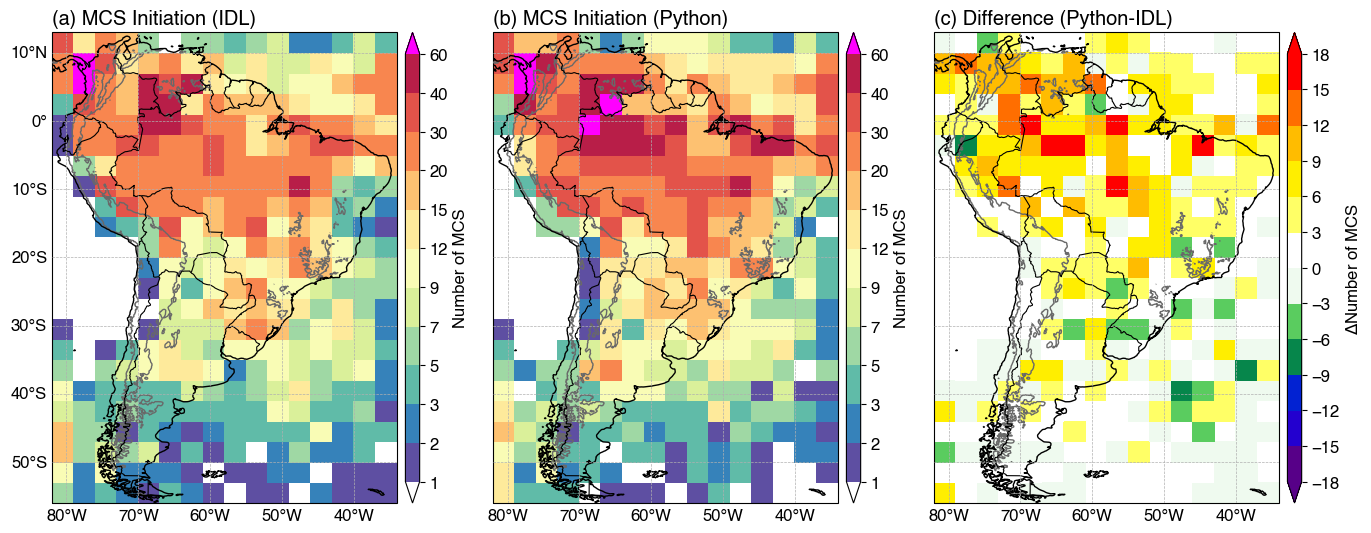

In [32]:
mcs_initcount_diff = mcs_initcount_py - mcs_initcount_idl
mcs_initcount_diff = np.ma.masked_where(mcs_initcount_diff == 0, mcs_initcount_diff)
dataarray = [mcs_initcount_idl, mcs_initcount_py, mcs_initcount_diff]
# levels = np.arange(1,10.1,1)
# levelsdiff = np.arange(-4, 4.1, 1)
levels = [1,2,3,5,7,9,12,15,20,30,40,60]
levels_diff = np.arange(-18, 18.1, 3)
levels = [levels, levels, levels_diff]
# cmappcp = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
# cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
# cmapdiff = copy.copy(mpl.cm.get_cmap('RdBu_r'))
cmaps = [cmap,cmap,cmapdiff]
titles = [f'(a) MCS Initiation (IDL)', f'(b) MCS Initiation (Python)', f'(c) Difference (Python-IDL)']
cblabels = ['Number of MCS','Number of MCS',r'$\Delta$'+'Number of MCS']
cbticks = levels
figname = f'{figdir}idl_python_mcs_irinitiation_map_annual.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_3panels(dataarray, xbins5, ybins5, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=oob_colors)